In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
import tensorflow as tf
import keras_cv
import keras
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image


tf.get_logger().setLevel('ERROR')

# logging.basicConfig(handlers=[logging.FileHandler('bot.log'), logging.StreamHandler()],
#                     level=logging.ERROR,
#                     format='[%(asctime)s: %(levelname)s: %(name)s] %(message)s',
#                     datefmt='%Y-%m-%d %H:%M:%S',
#                     encoding='utf-8')

# logger = logging.getLogger(__name__)

# tf_logger = logging.getLogger(tf.__name__).setLevel(logging.ERROR)
# keras_logger = logging.getLogger(keras.__name__).setLevel(logging.ERROR)
# keras_cv_logger = logging.getLogger(keras_cv.__name__).setLevel(logging.ERROR)

/home/ksiva/miniconda3/envs/keras-cv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [3]:
prompt_1 = "face, girl, pink hair, looking at the camera"
prompt_2 = "face, girl, smiling, red lipstick"
interpolation_steps = 5

encoding_1 = keras.ops.squeeze(model.encode_text(prompt_1))
encoding_2 = keras.ops.squeeze(model.encode_text(prompt_2))

interpolated_encodings = keras.ops.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

I0000 00:00:1708706823.288819   19856 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1708706823.300123   19856 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Encoding shape: (77, 768)


In [4]:
seed = 54321
noise = keras.random.normal((512 // 8, 512 // 8, 4), seed=seed)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

W0000 00:00:1708706880.646118   19855 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708706880.647697   19855 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708706880.650647   19855 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708706880.655825   19855 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708706880.657531   19855 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708706880.659218   19855 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step


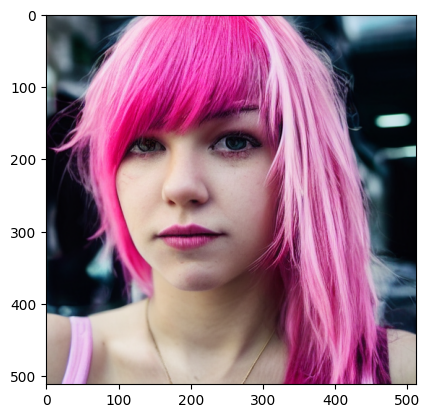

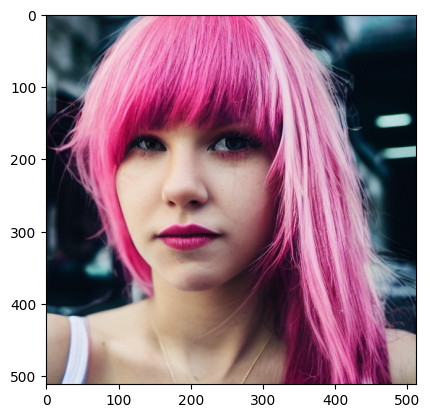

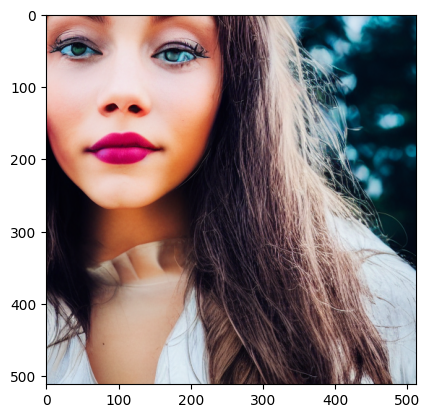

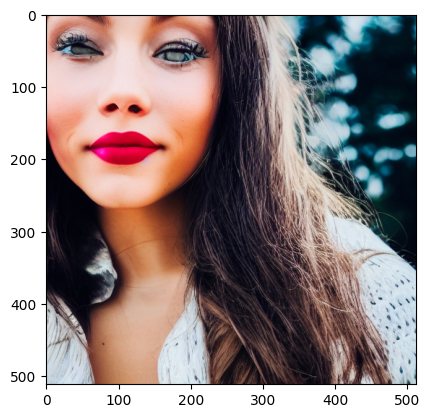

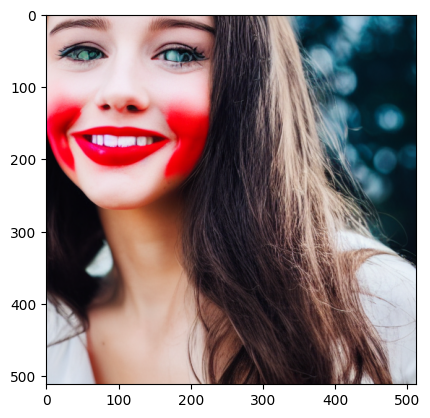

In [5]:
for image in images:
    plt.figure()
    plt.imshow(Image.fromarray(image))

In [6]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


export_as_gif(
    "test.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

In [8]:
interpolation_steps = 30
batch_size = 3
batches = interpolation_steps // batch_size

interpolated_encodings = keras.ops.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = keras.ops.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("test1.gif", images, rubber_band=True)

W0000 00:00:1708707264.746844   19851 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708707264.748297   19851 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708707264.750225   19851 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708707264.751600   19851 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708707264.753699   19851 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708707264.757983   19851 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708707264.759589   19851 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708707264.761204   19851 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
